In [3]:
from tensorflow.keras.utils import load_img, img_to_array
import tensorflow as tf
import numpy as np
import pandas as pd
import glob
from tensorflow.keras.layers import Input, Dense, Flatten, Reshape , Conv2D, MaxPooling2D, UpSampling2D , Cropping2D
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
import os

def load_images_from_directory(directory):
    images = []
    for root, _, filenames in os.walk(directory):
        for filename in filenames:
            # Check if the file is an image
            if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
                img_path = os.path.join(root, filename)
                image = load_img(img_path, target_size=(128,128))  # Resize image
                image_array = img_to_array(image)  # Convert to NumPy array
                image_array /= 255.0  # Normalize pixel values to [0, 1]
                images.append(image_array)
    images = np.array(images)
    return images

# Load images for x and y
x = []
x.extend(load_images_from_directory("/kaggle/input/image-enhancement-in-detecting-ocean-monument/underwater_scenes/trainA"))
x.extend(load_images_from_directory("/kaggle/input/image-enhancement-in-detecting-ocean-monument/underwater_imagenet/trainA"))
x.extend(load_images_from_directory("/kaggle/input/underwater-imagenet-dataset/underwater_imagenet/trainA"))
x.extend(load_images_from_directory("/kaggle/input/lsui-large-scale-underwater-image-dataset/LSUI/input"))

y = []
y.extend(load_images_from_directory("/kaggle/input/image-enhancement-in-detecting-ocean-monument/underwater_scenes/trainB"))
y.extend(load_images_from_directory("/kaggle/input/image-enhancement-in-detecting-ocean-monument/underwater_imagenet/trainB"))
y.extend(load_images_from_directory("/kaggle/input/underwater-imagenet-dataset/underwater_imagenet/trainB"))
y.extend(load_images_from_directory("/kaggle/input/lsui-large-scale-underwater-image-dataset/LSUI/GT"))

# Convert lists to numpy arrays
x_array = np.array(x)
y_array = np.array(y)

# Check the shapes of the arrays
print(f"x_array shape: {x_array.shape}")
print(f"y_array shape: {y_array.shape}")

x_array shape: (16292, 128, 128, 3)
y_array shape: (16292, 128, 128, 3)


In [4]:
test_data = []
test_data.extend(load_images_from_directory("/kaggle/input/image-enhancement-in-detecting-ocean-monument/test_samples/Inp"))
test_data.extend(load_images_from_directory("/kaggle/input/underwater-imagenet-dataset/underwater_imagenet/test"))

test_data_arr = np.array(test_data)
print(f"test_data_arr shape: {test_data_arr.shape}")

test_data_arr shape: (2328, 128, 128, 3)


In [5]:
import tensorflow as tf
from tensorflow.keras.layers import LeakyReLU, Conv2D, MaxPooling2D, UpSampling2D, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
def unet(input_shape=(128, 128, 3)):
    inputs = Input(input_shape, name='input_layer')

    # Encoder
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same', name='encoder_c1_1')(inputs)
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same', name='encoder_c1_2')(c1)
    p1 = MaxPooling2D((2, 2), name='encoder_p1')(c1)

    c2 = Conv2D(128, (3, 3), activation='relu', padding='same', name='encoder_c2_1')(p1)
    c2 = Conv2D(128, (3, 3), activation='relu', padding='same', name='encoder_c2_2')(c2)
    p2 = MaxPooling2D((2, 2), name='encoder_p2')(c2)

    c3 = Conv2D(256, (3, 3), activation='relu', padding='same', name='encoder_c3_1')(p2)
    c3 = Conv2D(256, (3, 3), activation='relu', padding='same', name='encoder_c3_2')(c3)
    p3 = MaxPooling2D((2, 2), name='encoder_p3')(c3)

    # Bottleneck
    c4 = Conv2D(512, (3, 3), activation='relu', padding='same', name='bottleneck_c4_1')(p3)
    # c4 = Conv2D(512, (3, 3), activation='relu', padding='same', name='bottleneck_c4_2')(c4)

    # Decoder
    u5 = UpSampling2D((2, 2), name='decoder_u5')(c4)
    u5 = Concatenate(name='decoder_concat5')([u5, c3])
    c5 = Conv2D(256, (3, 3), activation='relu', padding='same', name='decoder_c5_1')(u5)
    c5 = Conv2D(256, (3, 3), activation='relu', padding='same', name='decoder_c5_2')(c5)

    u6 = UpSampling2D((2, 2), name='decoder_u6')(c5)
    u6 = Concatenate(name='decoder_concat6')([u6, c2])
    c6 = Conv2D(128, (3, 3), activation='relu', padding='same', name='decoder_c6_1')(u6)
    c6 = Conv2D(128, (3, 3), activation='relu', padding='same', name='decoder_c6_2')(c6)

    u7 = UpSampling2D((2, 2), name='decoder_u7')(c6)
    u7 = Concatenate(name='decoder_concat7')([u7, c1])
    c7 = Conv2D(64, (3, 3), activation='relu', padding='same', name='decoder_c7_1')(u7)
    c7 = Conv2D(64, (3, 3), activation='relu', padding='same', name='decoder_c7_2')(c7)

    outputs = Conv2D(3, (1, 1), activation='sigmoid', name='output')(c7)

    model = tf.keras.Model(inputs, outputs)
    return model

# Create the updated model
model = unet()
model.compile(optimizer=Adam(learning_rate=1e-4), loss='mse', metrics=['accuracy'])

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_c1_1        │ (None, 128, 128,  │      1,792 │ input_layer[0][0] │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_c1_2        │ (None, 128, 128,  │     36,928 │ encoder_c1_1[0][… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_p1          │ (None, 64, 64,    │          0 │ encoder_c1_2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_c2_1        │ (None, 64, 64,    │     73,856 │ encoder_p1[0][0]  │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_c2_2        │ (None, 64, 64,    │    147,584 │ encoder_c2_1[0][… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_p2          │ (None, 32, 32,    │          0 │ encoder_c2_2[0][… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_c3_1        │ (None, 32, 32,    │    295,168 │ encoder_p2[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_c3_2        │ (None, 32, 32,    │    590,080 │ encoder_c3_1[0][… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_p3          │ (None, 16, 16,    │          0 │ encoder_c3_2[0][… │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bottleneck_c4_1     │ (None, 16, 16,    │  1,180,160 │ encoder_p3[0][0]  │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_u5          │ (None, 32, 32,    │          0 │ bottleneck_c4_1[… │
│ (UpSampling2D)      │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_concat5     │ (None, 32, 32,    │          0 │ decoder_u5[0][0], │
│ (Concatenate)       │ 768)              │            │ encoder_c3_2[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_c5_1        │ (None, 32, 32,    │  1,769,728 │ decoder_concat5[… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_c5_2        │ (None, 32, 32,    │    590,080 │ decoder_c5_1[0][… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_u6          │ (None, 64, 64,    │          0 │ decoder_c5_2[0][… │
│ (UpSampling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_concat6     │ (None, 64, 64,    │          0 │ decoder_u6[0][0]

 Total params: 5,423,235 (20.69 MB)

 Trainable params: 5,423,235 (20.69 MB)

 Non-trainable params: 0 (0.00 B)

I0000 00:00:1736077071.108065     113 service.cc:145] XLA service 0x7ccff0004160 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1736077071.108132     113 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1736077071.108138     113 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


I0000 00:00:1736077072.408660     113 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


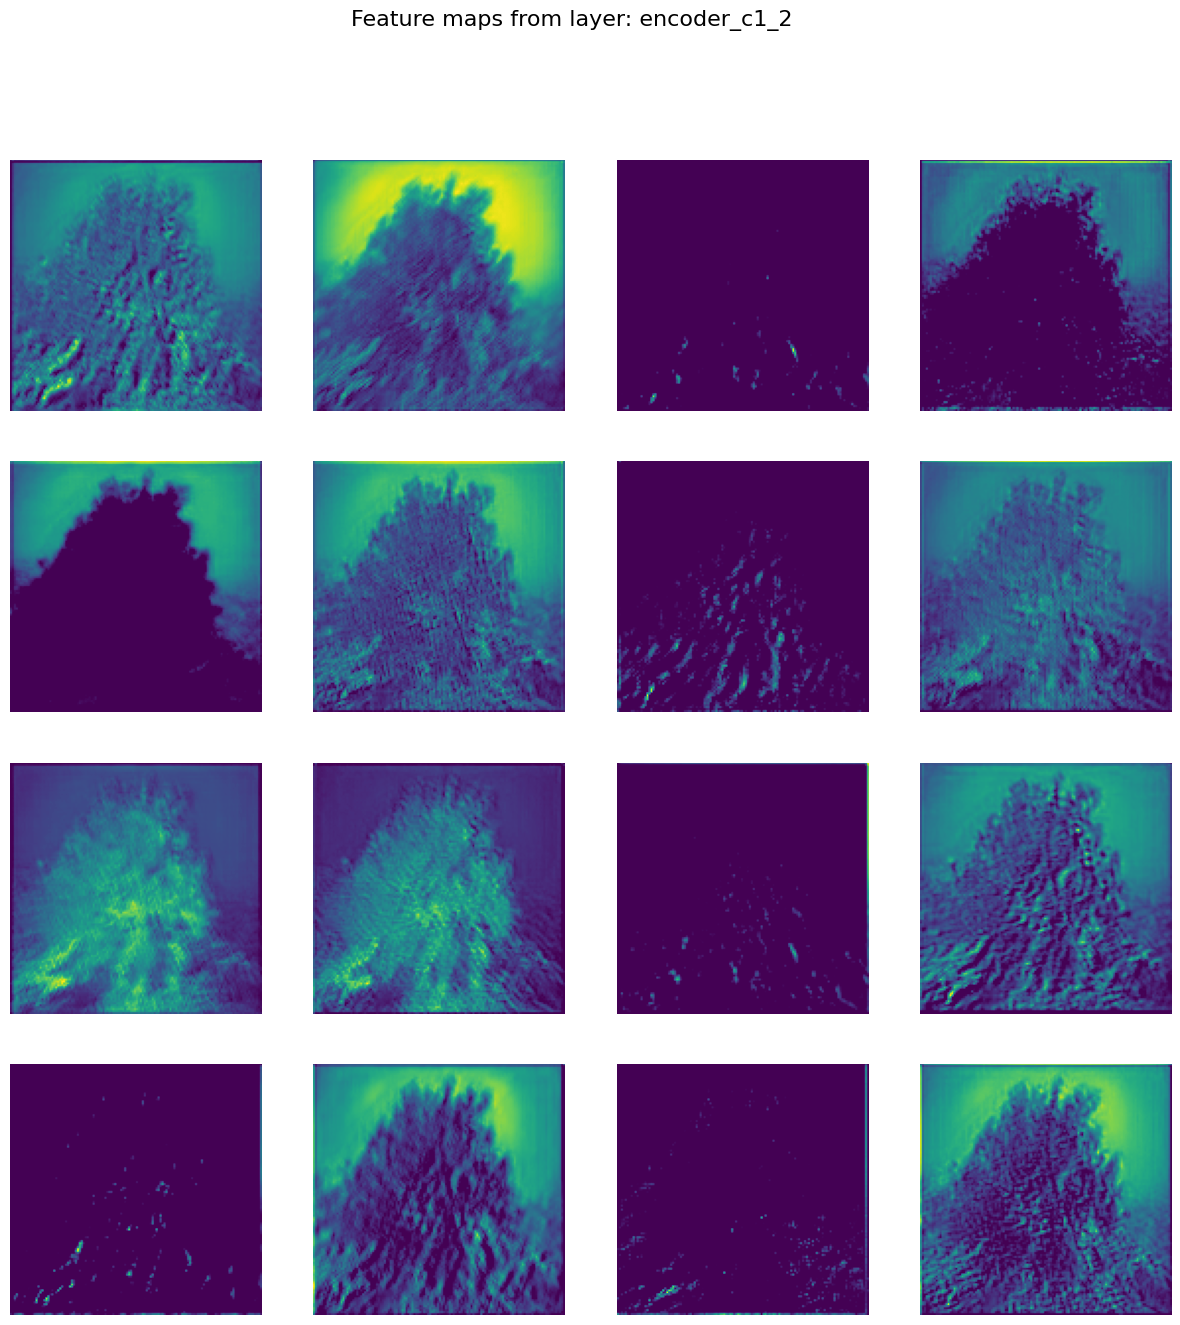

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 453ms/step


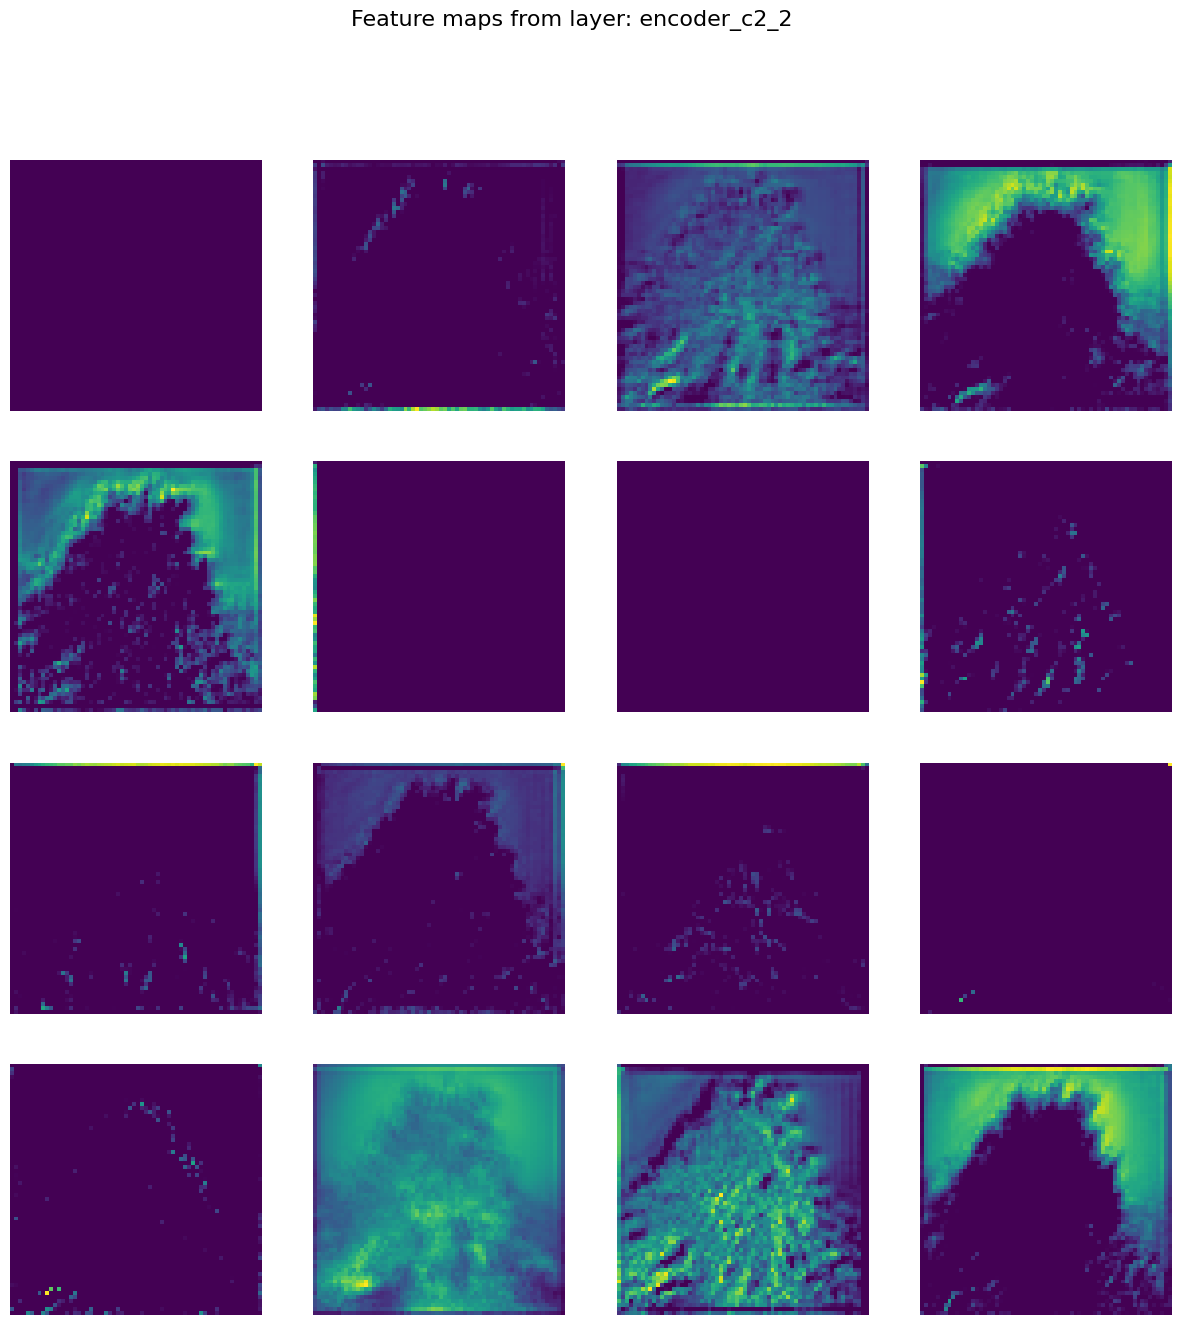

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 466ms/step


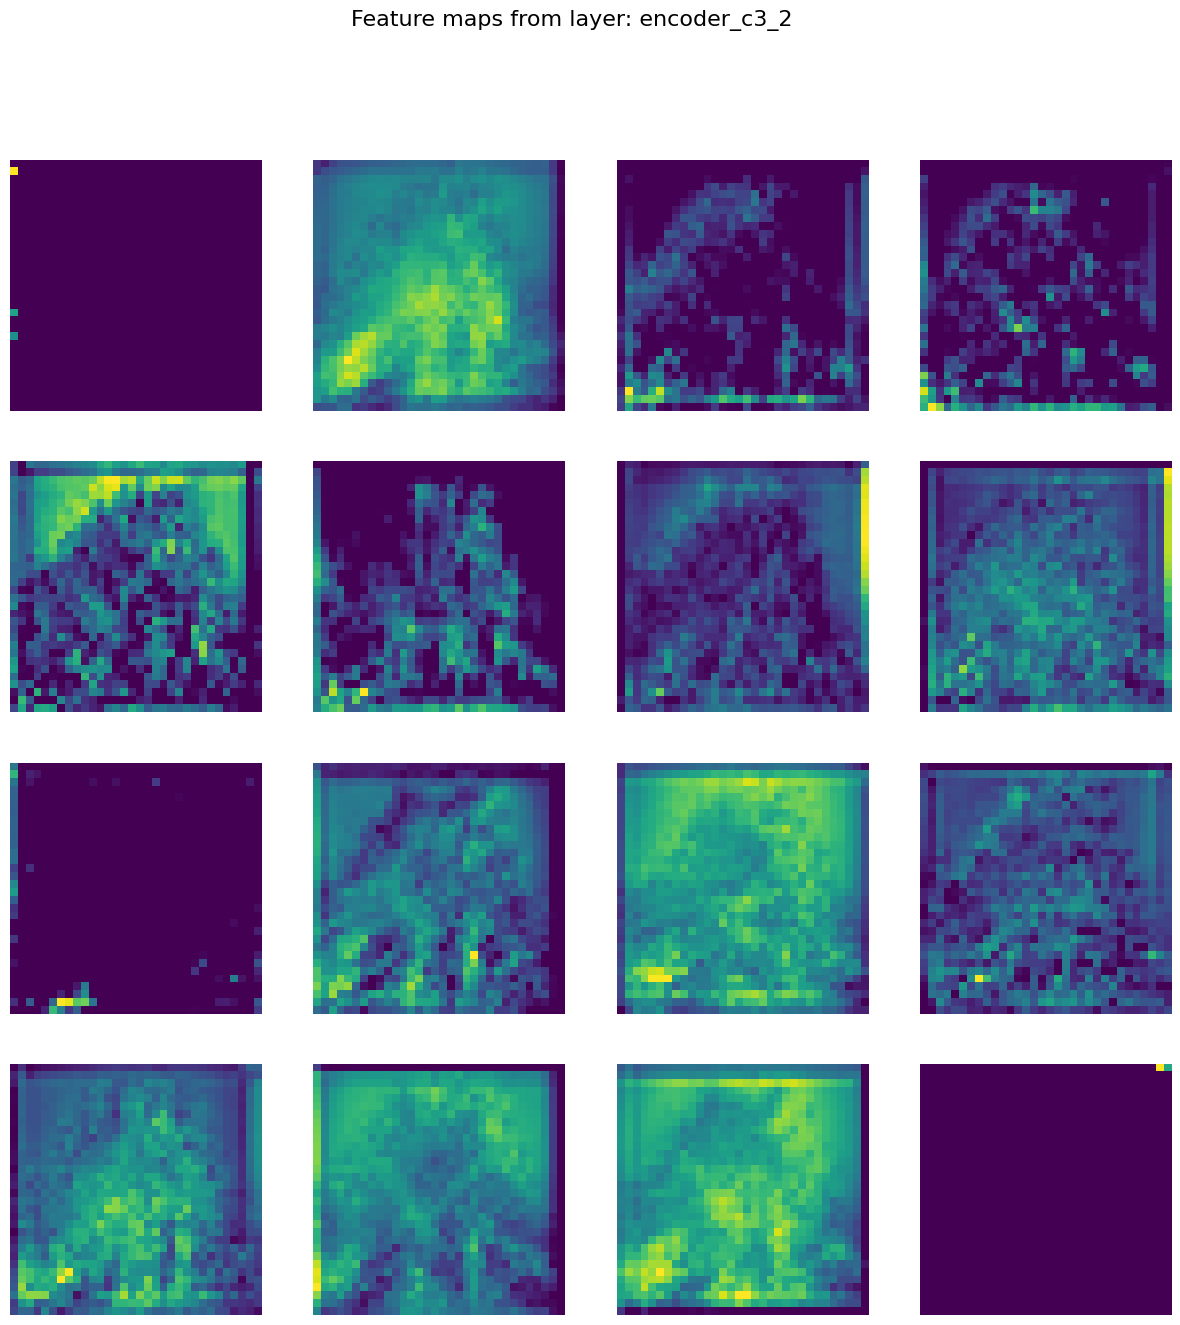

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 374ms/step


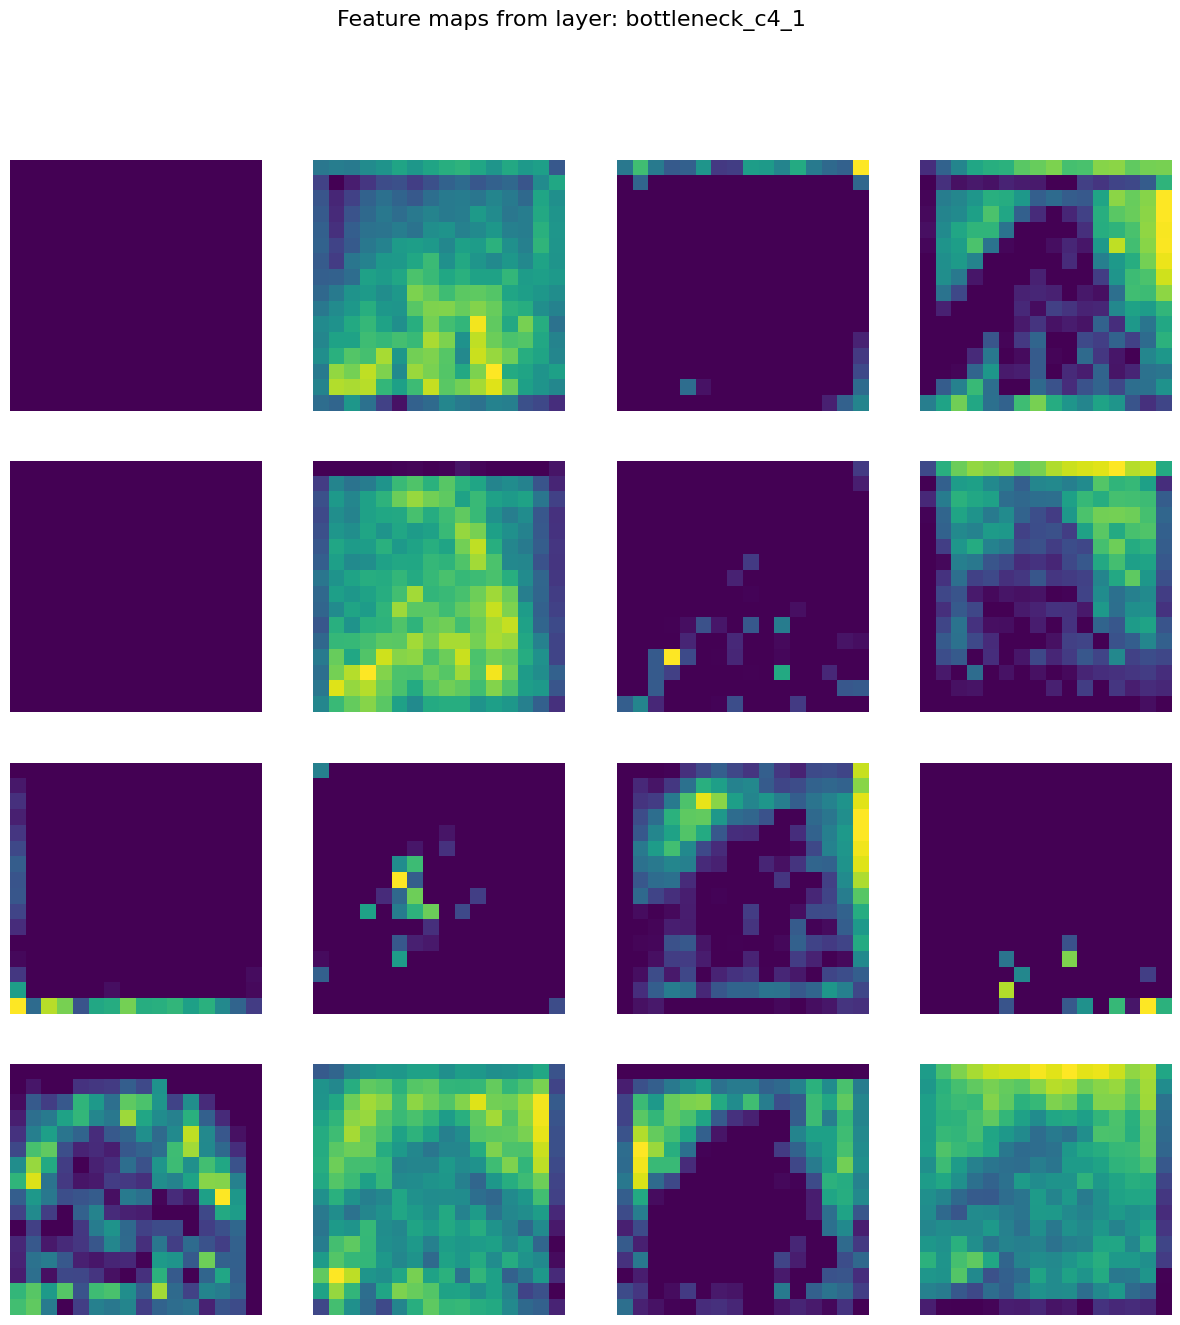

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 688ms/step


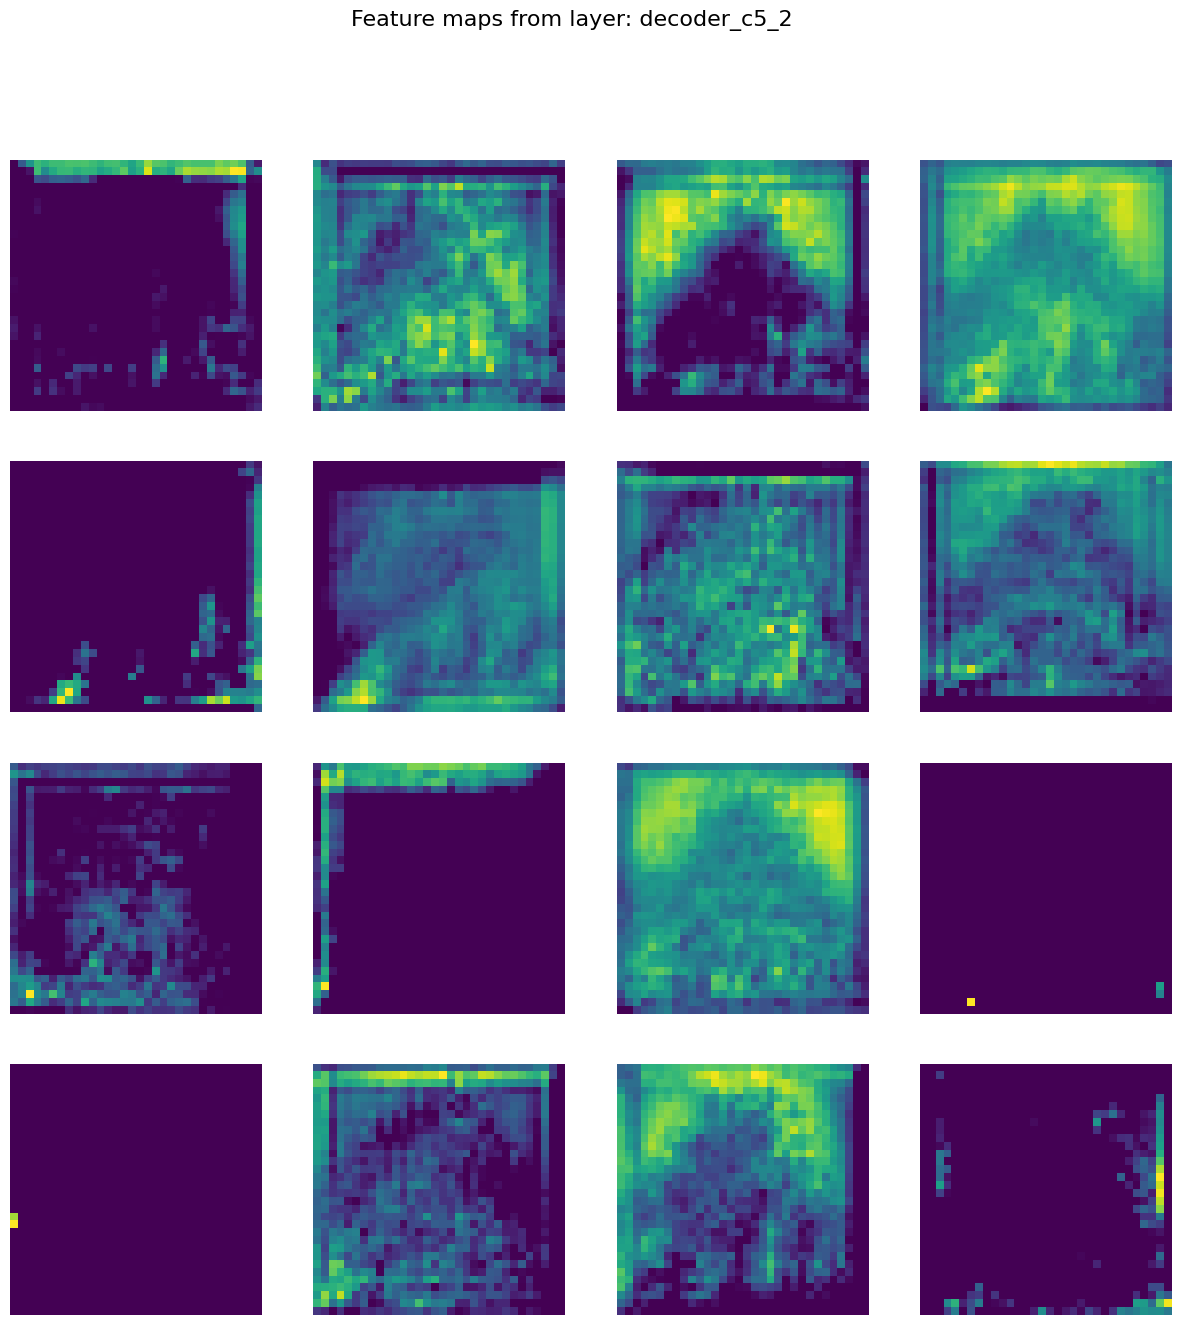

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


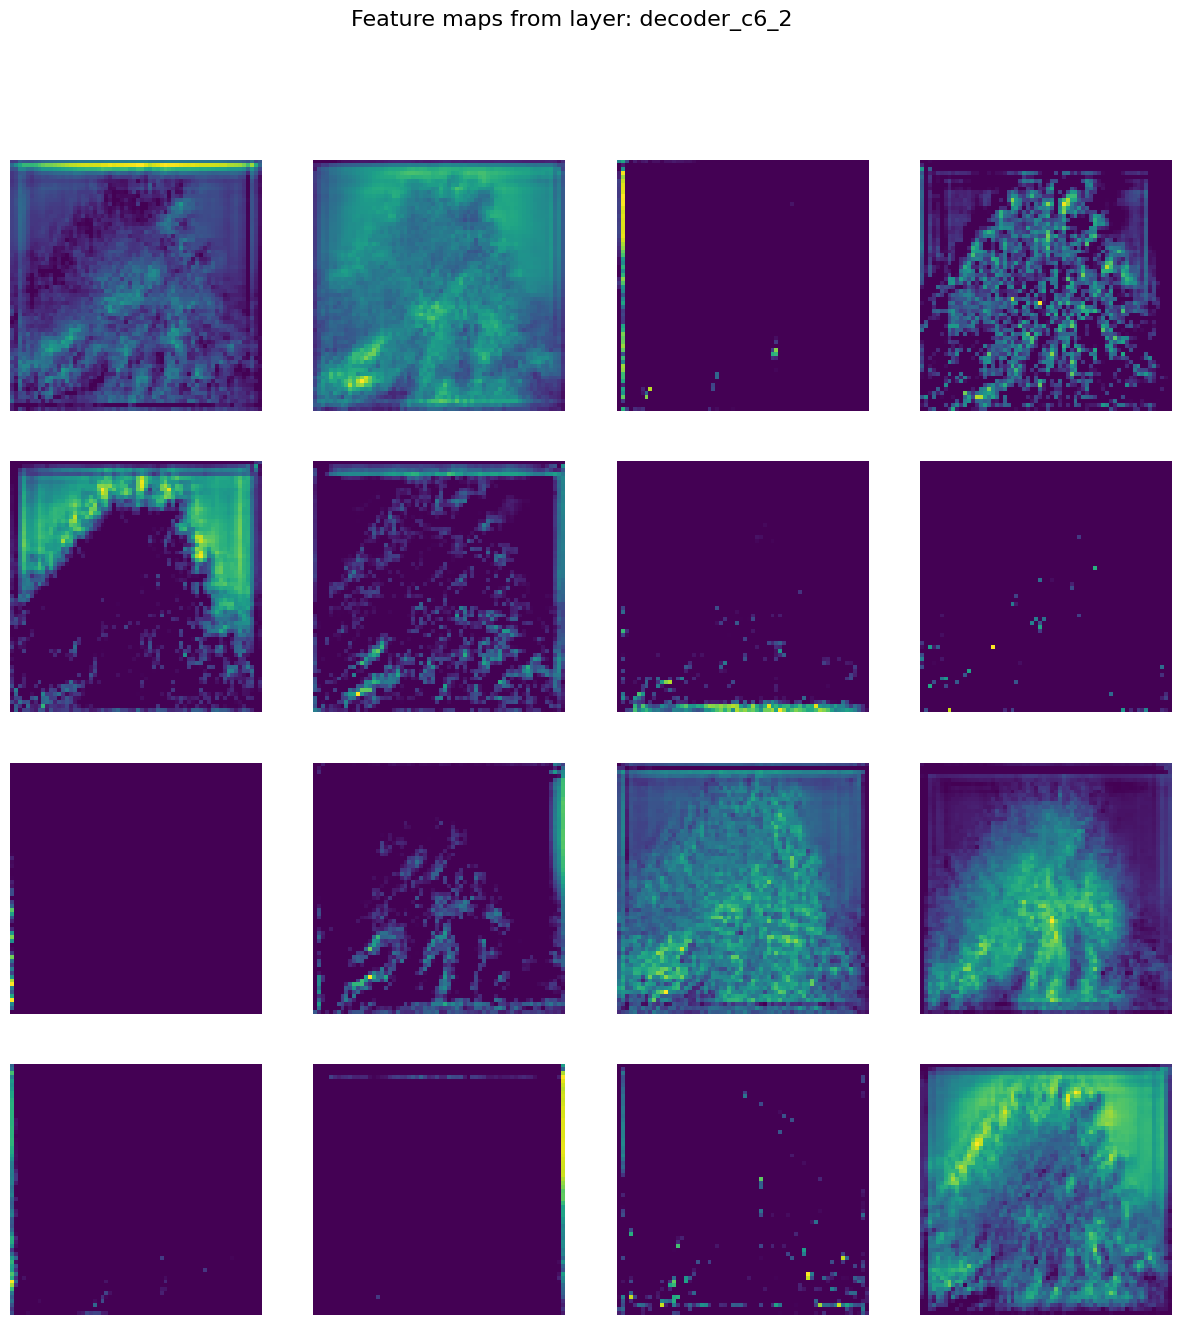

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 924ms/step


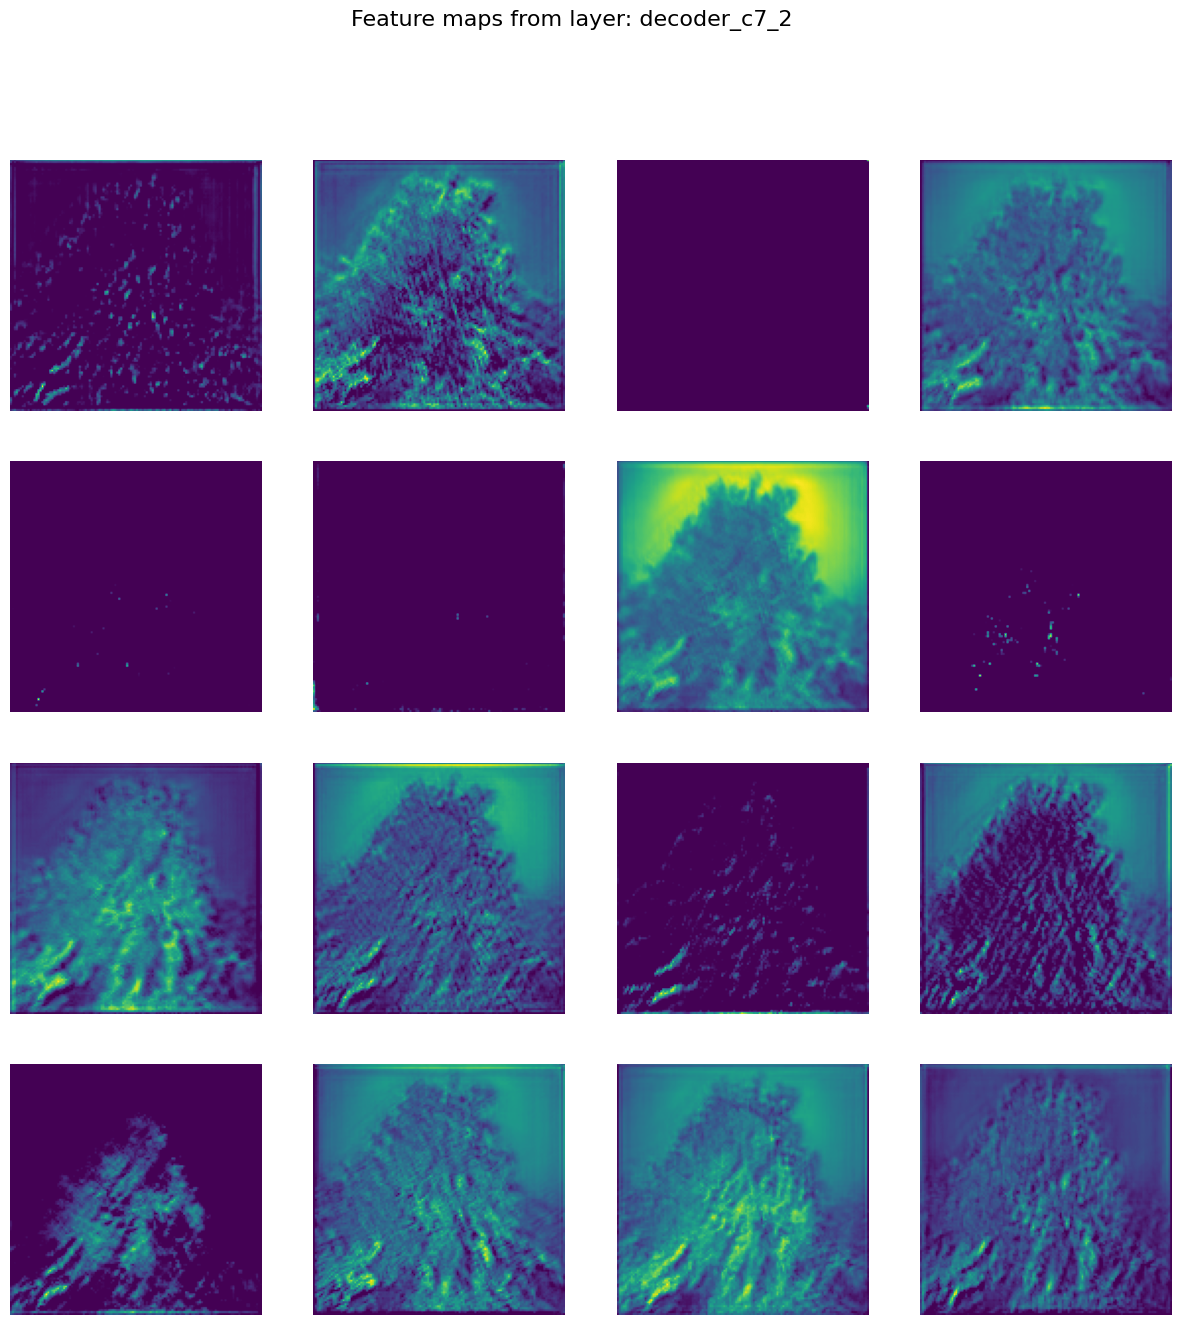

In [6]:
selected_layers = [
    'encoder_c1_2', 'encoder_c2_2', 'encoder_c3_2',  # Encoder
    'bottleneck_c4_1',                              # Bottleneck
    'decoder_c5_2', 'decoder_c6_2', 'decoder_c7_2'  # Decoder
]

def preprocess_image(image_path, target_size=(128, 128)):
    img = load_img(image_path, target_size=target_size)  # Load and resize the image
    img_array = img_to_array(img) / 255.0  # Normalize pixel values to [0, 1]
    img_array = np.expand_dims(img_array, axis=0)  # Adding this batch dimension ensures compatibility with the model's input expectations.
    return img_array

def visualize_feature_maps(model, image, layer_names):
    for layer_name in layer_names:
        intermediate_layer_model = Model(inputs=model.input, outputs=model.get_layer(layer_name).output)
        intermediate_output = intermediate_layer_model.predict(image)

        # Plot the feature maps
        num_filters = intermediate_output.shape[-1]
        plt.figure(figsize=(15, 15))
        for i in range(min(num_filters, 16)):  # Show only the first 16 feature maps 
            ax = plt.subplot(4, 4, i + 1)
            plt.imshow(intermediate_output[0, :, :, i], cmap='viridis')
            plt.axis('off')
        plt.suptitle(f"Feature maps from layer: {layer_name}", fontsize=16)
        plt.show()

image_path = "/kaggle/input/image-enhancement-in-detecting-ocean-monument/underwater_scenes/trainA/im_f1000_.jpg"
image = preprocess_image(image_path)

visualize_feature_maps(model, image, selected_layers)

In [7]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [8]:
history = model.fit(
    x_array, y_array,
    batch_size=16,
    epochs=50,
    validation_split=0.2,
    callbacks=[early_stopping],
    verbose=1,
    shuffle=True
    )


Epoch 1/50
815/815 ━━━━━━━━━━━━━━━━━━━━ 194s 206ms/step - accuracy: 0.5896 - loss: 0.0233 - val_accuracy: 0.6497 - val_loss: 0.0161
Epoch 2/50
815/815 ━━━━━━━━━━━━━━━━━━━━ 144s 177ms/step - accuracy: 0.6998 - loss: 0.0080 - val_accuracy: 0.7035 - val_loss: 0.0138
Epoch 3/50
815/815 ━━━━━━━━━━━━━━━━━━━━ 143s 175ms/step - accuracy: 0.7047 - loss: 0.0070 - val_accuracy: 0.6928 - val_loss: 0.0131
Epoch 4/50
815/815 ━━━━━━━━━━━━━━━━━━━━ 142s 175ms/step - accuracy: 0.7061 - loss: 0.0068 - val_accuracy: 0.6599 - val_loss: 0.0134
Epoch 5/50
815/815 ━━━━━━━━━━━━━━━━━━━━ 143s 175ms/step - accuracy: 0.7113 - loss: 0.0066 - val_accuracy: 0.6873 - val_loss: 0.0123
Epoch 6/50
815/815 ━━━━━━━━━━━━━━━━━━━━ 142s 175ms/step - accuracy: 0.7127 - loss: 0.0064 - val_accuracy: 0.6970 - val_loss: 0.0122
Epoch 7/50
815/815 ━━━━━━━━━━━━━━━━━━━━ 142s 175ms/step - accuracy: 0.7185 - loss: 0.0062 - val_accuracy: 0.7017 - val_loss: 0.0116
Epoch 8/50
815/815 ━━━━━━━━━━━━━━━━━━━━ 142s 175ms/step - accuracy: 0.7207 -

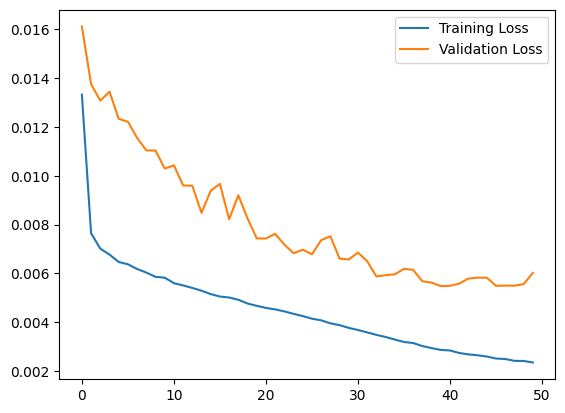

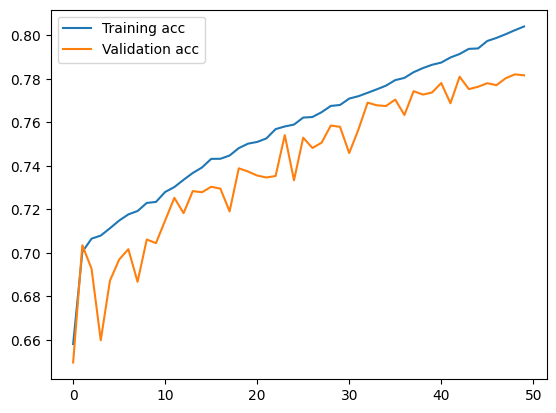

In [9]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

# Visualising the train vs validation accuracy
plt.plot(history.history['accuracy'], label='Training acc')
plt.plot(history.history['val_accuracy'], label='Validation acc')
plt.legend()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


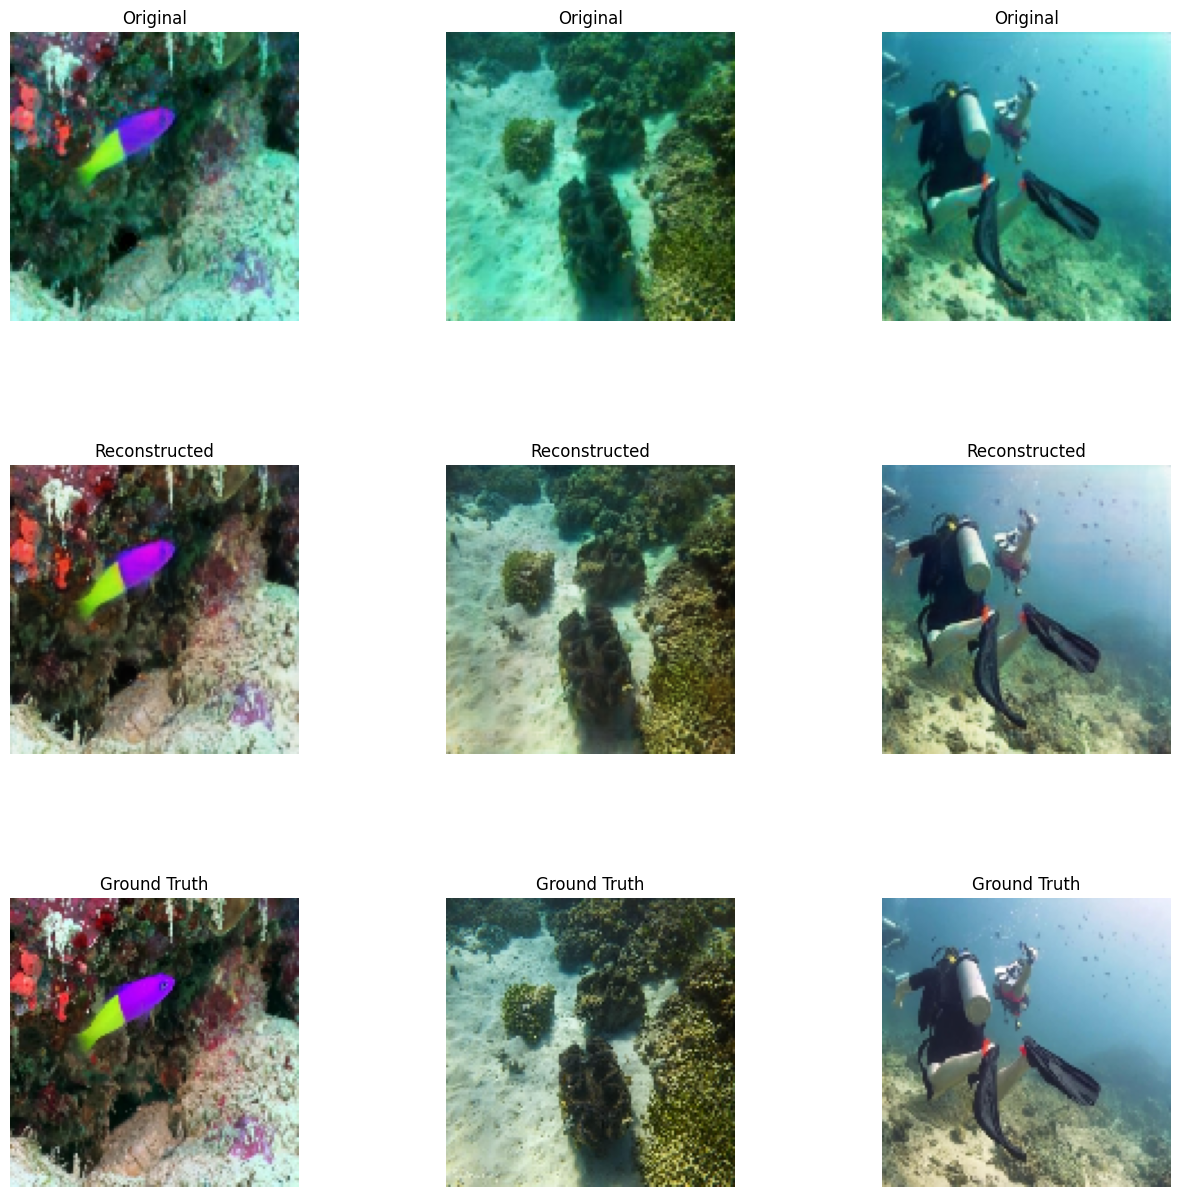

In [11]:
import matplotlib.pyplot as plt

# Generate predictions from the model for visualization
decoded_imgs = model.predict(x_array[:20]) 

# Set the number of images to display
n = 3  # Adjust the number to display three examples

# Create a larger figure for better visualization
plt.figure(figsize=(15, 15))  # Adjust the size based on your needs

# Adjust spacing between images
plt.subplots_adjust(wspace=0.5, hspace=0.5)

for i in range(n):
    # Original poor-quality image
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(x_array[i+10].astype("float32"))
    plt.title("Original")
    plt.axis("off")

    # Model's reconstructed (enhanced) image
    ax = plt.subplot(3, n, i + n + 1)
    plt.imshow(decoded_imgs[i+10].astype("float32"))
    plt.title("Reconstructed")
    plt.axis("off")
    
    # Ground truth enhanced image
    ax = plt.subplot(3, n, i + 2 * n + 1)
    plt.imshow(y_array[i+10].astype("float32"))  
    plt.title("Ground Truth")
    plt.axis("off")

plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


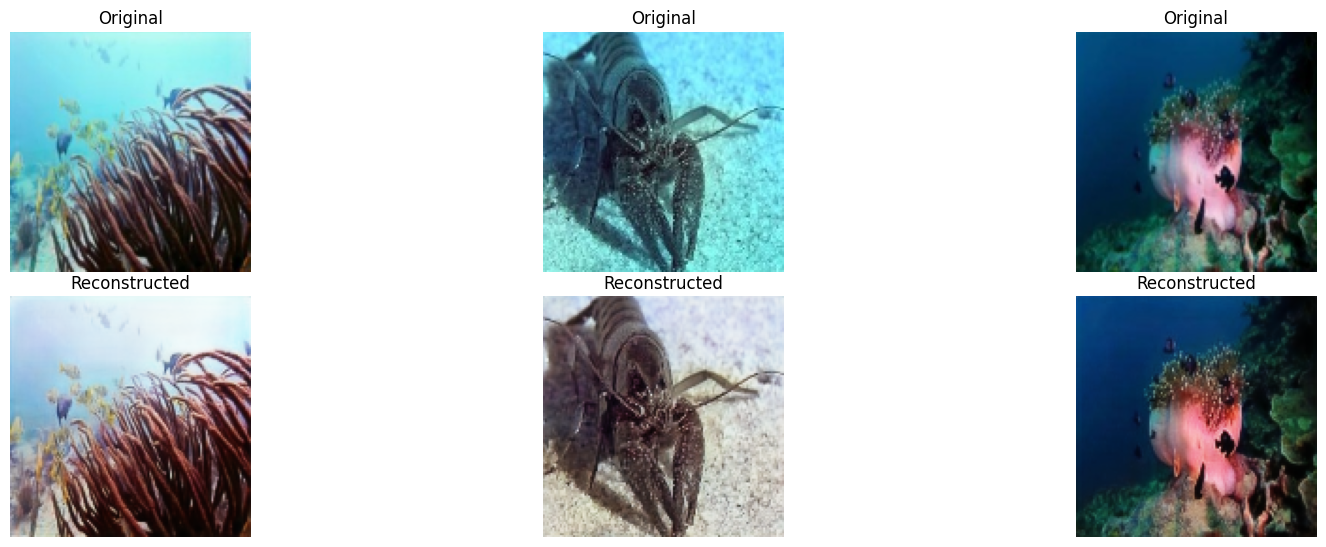

In [19]:
import matplotlib.pyplot as plt

# Generate predictions from the model for visualization
decoded_imgs = model.predict(test_data_arr[:10]) 

# Set the number of images to display
n = 3  # Adjust based on your preference

# Create a larger figure for better visualization
plt.figure(figsize=(20, 10))

# Adjust spacing between images
plt.subplots_adjust(wspace=0.1, hspace=0.1)

for i in range(n):
    # Original poor-quality image
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(test_data[i])
    plt.title("Original")
    plt.axis("off")

    # Model's reconstructed (enhanced) image
    ax = plt.subplot(3, n, i + n + 1)
    plt.imshow(decoded_imgs[i])
    plt.title("Reconstructed")
    plt.axis("off")
    

plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


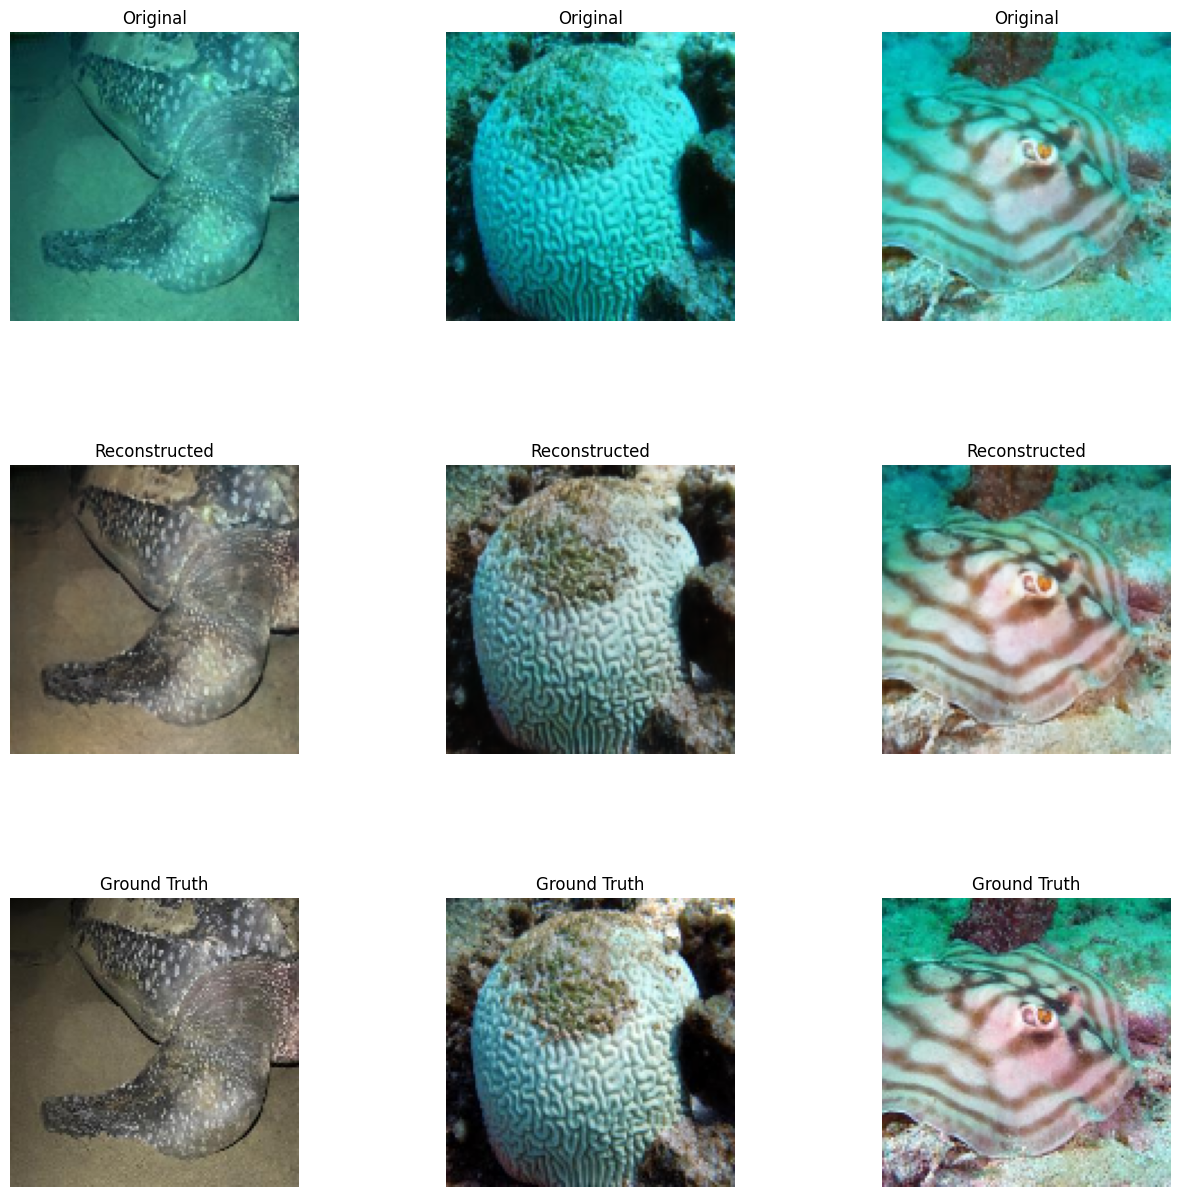

In [25]:
import matplotlib.pyplot as plt

# Generate predictions from the model for visualization
decoded_imgs = model.predict(x_array[6535:6550]) 

# Set the number of images to display
n = 3  # Adjust the number to display three examples

# Create a larger figure for better visualization
plt.figure(figsize=(15, 15))  # Adjust the size based on your needs

# Adjust spacing between images
plt.subplots_adjust(wspace=0.5, hspace=0.5)

for i in range(n):
    # Original poor-quality image
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(x_array[i+6535])
    plt.title("Original")
    plt.axis("off")

    # Model's reconstructed (enhanced) image
    ax = plt.subplot(3, n, i + n + 1)
    plt.imshow(decoded_imgs[i])
    plt.title("Reconstructed")
    plt.axis("off")
    
    # Ground truth enhanced image
    ax = plt.subplot(3, n, i + 2 * n + 1)
    plt.imshow(y_array[i+6535])  
    plt.title("Ground Truth")
    plt.axis("off")

plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


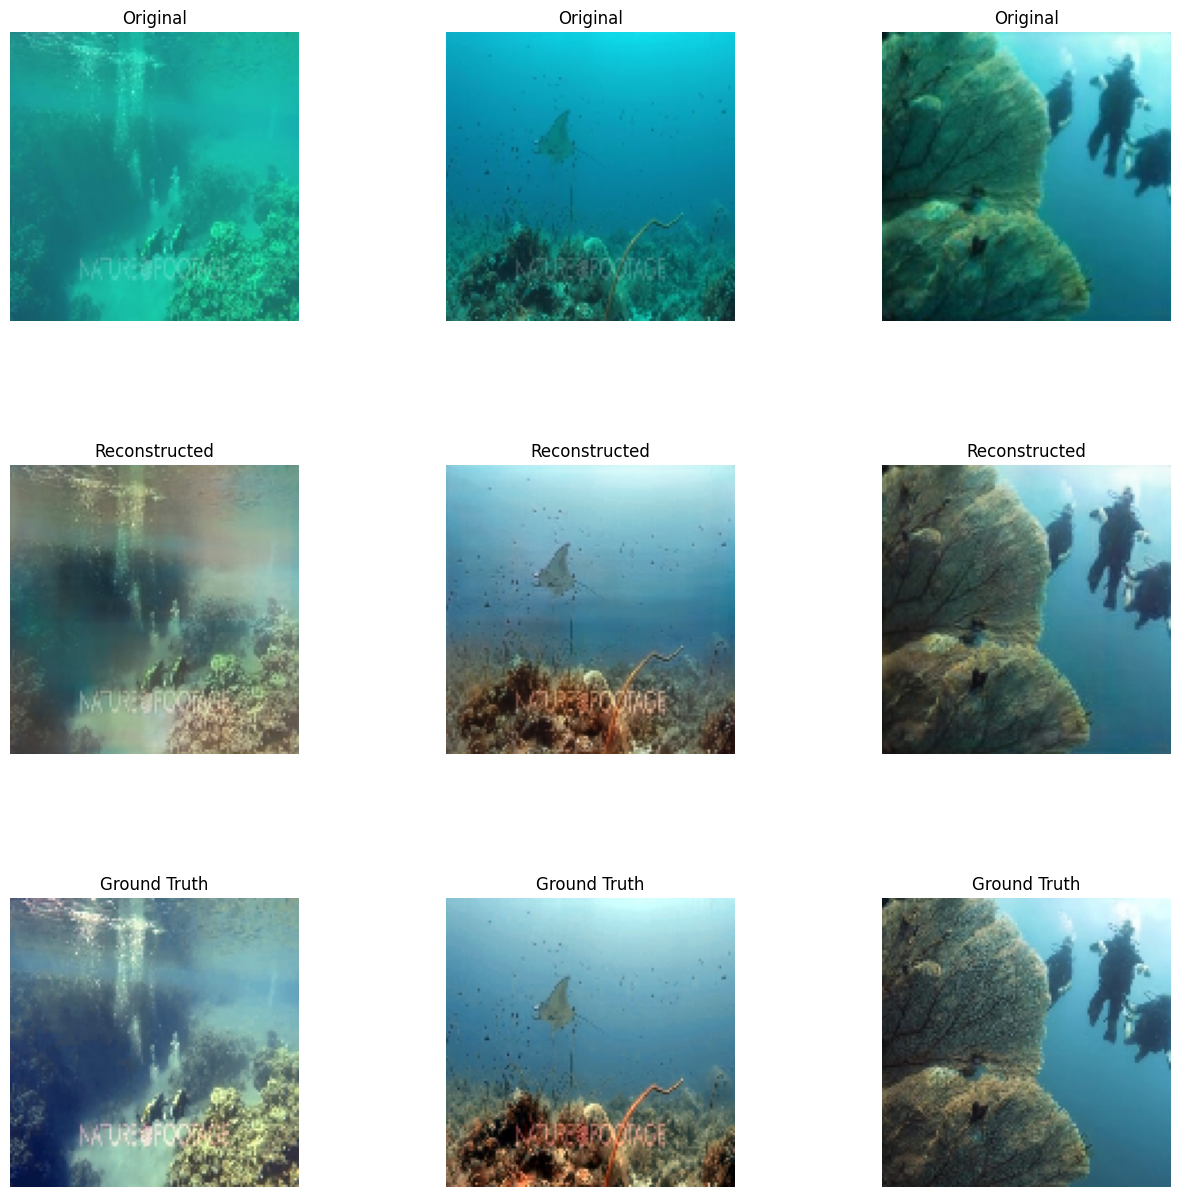

In [26]:
import matplotlib.pyplot as plt

# Generate predictions from the model for visualization
decoded_imgs = model.predict(x_array[16286:16292]) 

# Set the number of images to display
n = 3  # Adjust the number to display three examples

# Create a larger figure for better visualization
plt.figure(figsize=(15, 15))  # Adjust the size based on your needs

# Adjust spacing between images
plt.subplots_adjust(wspace=0.5, hspace=0.5)

for i in range(n):
    # Original poor-quality image
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(x_array[i+16286])
    plt.title("Original")
    plt.axis("off")

    # Model's reconstructed (enhanced) image
    ax = plt.subplot(3, n, i + n + 1)
    plt.imshow(decoded_imgs[i])
    plt.title("Reconstructed")
    plt.axis("off")
    
    # Ground truth enhanced image
    ax = plt.subplot(3, n, i + 2 * n + 1)
    plt.imshow(y_array[i+16286])  
    plt.title("Ground Truth")
    plt.axis("off")

plt.show()


In [30]:
model.save('unet.h5')